# Validating time and temperature parsing between ChemicalTagger, ChatGPT, and manual labelling

In [38]:
import numpy as np

from pathlib import Path
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from collections import Counter
import numpy as np
import os
import sys
import textdistance
import json
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from synoracle import ingredients, sequence
except ModuleNotFoundError:
    module_path = os.path.abspath(os.path.join('c:\\Users\\d23895jm\\Desktop\\Work master 2022\\Active research Projects\\synoracle_publication\\SyntheticOracle'))
    if module_path not in sys.path:
        sys.path.append(module_path)
    from synoracle import ingredients, sequence

try:
    from synparagraph import SynParagraph
except ModuleNotFoundError:
    module_path = os.path.abspath(os.path.join('c:\\Users\\d23895jm\\Desktop\\Work master 2022\\Active research Projects\\synoracle-preprocessing\\synoracle'))
    if module_path not in sys.path:
        sys.path.append(module_path)
    from synparagraph import SynParagraph

from tqdm.notebook import tqdm, trange

def li_iterate(li):
    l = iter(li)
    for _ in trange(len(li)):
        yield next(l)

## Importing manual sequences

In [39]:
manual_sequences = pd.read_csv('D:/nist_manual_sequences.csv')

unit_converter = {
    'L': 'volume',
    'mL': 'volume',
    'drops': 'volume',
    'g': 'mass',
    'mg': 'mass',
    'mmol': 'other_amount',
    'nan':np.nan,
    np.nan:np.nan
}

for c,x in manual_sequences.iterrows():
    new_chemicals = []
    try:
        str(eval(x['chemicals and amount sued']))
    except TypeError:
        # print(c, x['chemicals and amount sued'])
        pass
    else:
        try:
            eval(x['chemicals and amount sued']).items()
        except AttributeError:
            pass
        else:
            for y in eval(x['chemicals and amount sued']).items():
                # print(y)
                if len(y[1].split(' ')) >1:
                    #print(unit_converter[y[1].split(' ')[1]])
                    new_chemicals.append({'name': y[0], unit_converter[y[1].split(' ')[1]]: y[1]})
                else:
                    new_chemicals.append({'name': y[0]})
    manual_sequences.loc[c, 'new_chemicals'] = str(new_chemicals)
manual_sequences['identifier'] = manual_sequences['Paper'] + '.' + manual_sequences['Paragraph'].astype(str)    
manual_sequences['time'] = manual_sequences['time'].astype(str)
manual_sequences['temp'] = manual_sequences['temp'].astype(str)
manual_sequences['time']

0            []
1            []
2            []
3      ['24 h']
4            []
         ...   
437          []
438          []
439          []
440          []
441          []
Name: time, Length: 442, dtype: object

## Importing ChatGPT-labelled synthesis sequences

In [40]:
with open('../NIST sequences.json', 'r') as f:
    raw_gpt = json.load(f)
    gpt_dfs = [pd.DataFrame(x) for x in raw_gpt]

gpt_sequences = {x['paper'].unique()[0] + '.' + x['paragraph'].unique()[0]: x for x in gpt_dfs}

## Importing ChemicalTagger-labelled synthesis sequences

In [57]:
source_dir = Path(r"D:/NIST-ZIF-8")


## Creating and comparing `Conditions` objects

In [58]:
sequence_info = {}
condensed_sequence_info = {}
time_info = {}
temp_info = {}
for x in manual_sequences['identifier'].unique():
    print(f'{x}\n--------------')
    manual = sequence.Sequence(manual_sequences[manual_sequences['identifier']==x].reset_index(drop=True))
    manual.extract_chemicals()
    manual.extract_conditions()


    cde_paragraph = SynParagraph(paper_identifier=x, source_directory=source_dir)
    cde_sequence = sequence.Sequence(cde_paragraph.raw_synthesis)
    cde_sequence.drop_invalid_lines()
    cde_sequence.extract_chemicals()
    cde_sequence.extract_conditions()


    gpt = sequence.Sequence(gpt_sequences[x])
    gpt.drop_invalid_lines()
    gpt.extract_chemicals()
    gpt.extract_conditions()   


    time_info[x] = {
        'manual': manual.conditions.times['Time (min)'].tolist(),
        'cde': cde_sequence.conditions.times['Time (min)'].tolist(),
        'gpt': gpt.conditions.times['Time (min)'].tolist()
    }

    temp_info[x] = {
        'manual': manual.conditions.temps['T (K)'].tolist(),
        'cde': cde_sequence.conditions.temps['T (K)'].tolist(),
        'gpt': gpt.conditions.temps['T (K)'].tolist()
    }


009589722013797966.16
--------------
Aic13970.6
--------------


Aic13970.7
--------------
Aic14525.0
--------------
anie201104383.0
--------------
c1ce05780d.0
--------------
c2cc34893d.0
--------------
c2jm15685g.24
--------------
c3ta11483j.23
--------------
c4ee01009d.0
--------------
Time extraction failed for: "A few hours", original was "A few hours"
ValueError could not convert string to float: 'few'
Time extraction failed for: "A few hours", original was "A few hours"
ValueError could not convert string to float: 'few'
Time extraction failed for: "a few hours", original was "for a few hours"
ValueError could not convert string to float: 'few'
Time extraction failed for: "a few hours", original was "for a few hours"
ValueError could not convert string to float: 'few'
Time extraction failed for: "a few hours", original was "for a few hours"
ValueError could not convert string to float: 'few'
Time extraction failed for: "a few hours", original was "for a few hours"
ValueError could not convert string to float: 'few'
c5ra01183c.11
-------------

jmicromeso201211012.33
--------------
jp407792a.25
--------------


jp407792a.26
--------------
jp5081466.1
--------------
jp5081466.2
--------------
jp5081466.3
--------------
jp5081466.4
--------------
jp5081466.5
--------------
jp5081466.6
--------------
jp5081466.7
--------------


jp5081466.8
--------------
jp5081466.9
--------------
jp5081466.10
--------------
JPOWTEC201309013.44
--------------
jssc201406017.48
--------------
jultsonch201704030.47
--------------
jz300855a.1
--------------
jz300855a.2
--------------
jz300855a.3
--------------
la401471g.31
--------------
s1872-2067(14)60292-8.30
--------------


s10450-012-9407-1.18
--------------
s12274-014-0501-4.0
--------------


In [59]:
temp_df = pd.DataFrame(temp_info).T
time_df = pd.DataFrame(time_info).T


## Analysing extracted time values

In [95]:
for c,x in time_df.iterrows():
    try:
        gpt_precision = len(Counter(x['manual']) & Counter(x['gpt']))/len(Counter(x['manual']))
    except ZeroDivisionError:
        gpt_precision = 0

    time_df.loc[c,'gpt_precision'] = gpt_precision

    try:
        gpt_recall = len(Counter(x['manual']) & Counter(x['gpt']))/len(Counter(x['gpt']))
    except ZeroDivisionError:
        gpt_recall = 0

    time_df.loc[c,'gpt_recall'] = gpt_recall
    try:
        time_df.loc[c, 'gpt_f1'] = 2*gpt_recall*gpt_precision/(gpt_recall+gpt_precision)
    except ZeroDivisionError:
        time_df.loc[c, 'gpt_f1'] = 0

    try:
        gpt_value_match = sum(((Counter(x['manual']) & Counter(x['gpt'])).values()))/max([sum(Counter(x['manual']).values()), sum(Counter(x['gpt']).values())])
    except ZeroDivisionError:
        gpt_value_match = np.nan
    time_df.loc[c,'gpt_value_match'] = float(gpt_value_match)


    try:
        cde_precision = len(Counter(x['manual']) & Counter(x['cde']))/len(Counter(x['manual']))
    except ZeroDivisionError:
        cde_precision = 0

    time_df.loc[c,'cde_precision'] = cde_precision

    try:
        cde_recall = len(Counter(x['manual']) & Counter(x['cde']))/len(Counter(x['cde']))
    except ZeroDivisionError:
        cde_recall = 0

    time_df.loc[c,'cde_recall'] = cde_recall
    try:
        time_df.loc[c, 'cde_f1'] = 2*cde_recall*cde_precision/(cde_recall+cde_precision)
    except ZeroDivisionError:
        time_df.loc[c, 'cde_f1'] = 0

    try:
        cde_value_match = sum(((Counter(x['manual']) & Counter(x['cde'])).values()))/max([sum(Counter(x['manual']).values()), sum(Counter(x['cde']).values())])
    except ZeroDivisionError:
        cde_value_match = np.nan
    time_df.loc[c,'cde_value_match'] = float(cde_value_match)

    try:
        cross_precision = len(Counter(x['cde']) & Counter(x['gpt']))/len(Counter(x['cde']))
    except ZeroDivisionError:
        cross_precision = 0

    time_df.loc[c,'cross_precision'] = cross_precision

    try:
        cross_recall = len(Counter(x['cde']) & Counter(x['gpt']))/len(Counter(x['gpt']))
    except ZeroDivisionError:
        cross_recall = 0

    time_df.loc[c,'cross_recall'] = cross_recall
    try:
        time_df.loc[c, 'cross_f1'] = 2*cross_recall*cross_precision/(cross_recall+cross_precision)
    except ZeroDivisionError:
        time_df.loc[c, 'cross_f1'] = 0


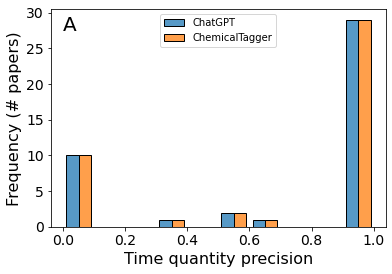

Time value parsing precision:
---------------------------------------
Chemtagger average:  72.1 % +/-  42.8 %
GPT average:         72.1 % +/-  42.8 %


In [112]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
bins = np.linspace(0,1,11)
sns.histplot(
    { 'ChatGPT':  time_df['gpt_precision'], 'ChemTagger':time_df['cde_precision'],}, 
    ax=ax, 
    bins=bins, 
    multiple='dodge', 
    shrink=0.8
    )

legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.set_xlabel('Time quantity precision', fontsize=16)
ax.set_ylabel('Frequency (# papers)', fontsize=16)
ax.legend(handles, ['ChatGPT', 'ChemicalTagger'], loc=9)
ax.annotate('A', (0,27.5),fontsize=20)
ax.tick_params(labelsize=14)
plt.show()
print('Time value parsing precision:\n---------------------------------------')
print(f"Chemtagger average: {round(100*time_df['cde_precision'].mean(),1):>5} % +/- {round(100*time_df['cde_precision'].std(),1):>5} %")
print(f"GPT average: {round(100*time_df['gpt_precision'].mean(),1):>12} % +/- {round(100*time_df['gpt_precision'].std(),1):>5} %")


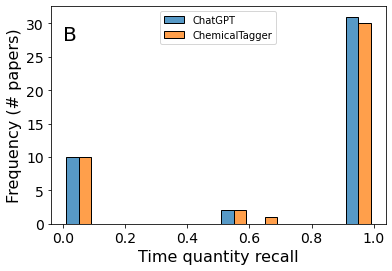

Time value parsing recall:
---------------------------------------
Chemtagger average:  73.6 % +/-  42.6 %
GPT average:         74.4 % +/-  42.8 %


In [114]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
bins = np.linspace(0,1,11)
sns.histplot(
    { 'ChatGPT':  time_df['gpt_recall'], 'ChemTagger':time_df['cde_recall'],}, 
    ax=ax, 
    bins=bins, 
    multiple='dodge', 
    shrink=0.8
    )

legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.set_xlabel('Time quantity recall', fontsize=16)
ax.set_ylabel('Frequency (# papers)', fontsize=16)
ax.legend(handles, ['ChatGPT', 'ChemicalTagger'], loc=9)
ax.annotate('B', (0,27.5),fontsize=20)
ax.tick_params(labelsize=14)
plt.show()
print('Time value parsing recall:\n---------------------------------------')
print(f"Chemtagger average: {round(100*time_df['cde_recall'].mean(),1):>5} % +/- {round(100*time_df['cde_recall'].std(),1):>5} %")
print(f"GPT average: {round(100*time_df['gpt_recall'].mean(),1):>12} % +/- {round(100*time_df['gpt_recall'].std(),1):>5} %")

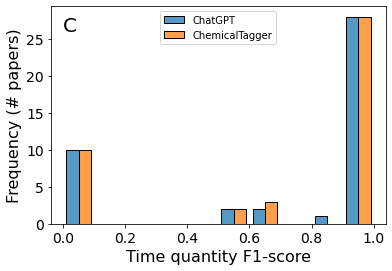

Time value parsing F1-score:
---------------------------------------
Chemtagger average:  72.1 % +/-  42.2 %
GPT average:         72.4 % +/-  42.2 %


In [118]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
bins = np.linspace(0,1,11)
sns.histplot(
    { 'ChatGPT':  time_df['gpt_f1'], 'ChemTagger':time_df['cde_f1'],}, 
    ax=ax, 
    bins=bins, 
    multiple='dodge', 
    shrink=0.8
    )

legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.set_xlabel('Time quantity F1-score', fontsize=16)
ax.set_ylabel('Frequency (# papers)', fontsize=16)
ax.legend(handles, ['ChatGPT', 'ChemicalTagger'], loc=9)
ax.annotate('C', (0,26),fontsize=20)
ax.tick_params(labelsize=14)
plt.show()
print('Time value parsing F1-score:\n---------------------------------------')
print(f"Chemtagger average: {round(100*time_df['cde_f1'].mean(),1):>5} % +/- {round(100*time_df['cde_f1'].std(),1):>5} %")
print(f"GPT average: {round(100*time_df['gpt_f1'].mean(),1):>12} % +/- {round(100*time_df['gpt_f1'].std(),1):>5} %")

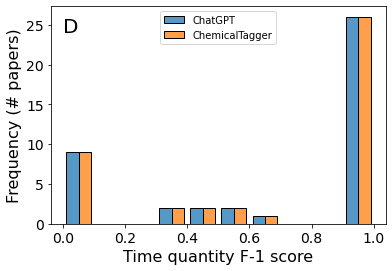

Time value parsing recall:
---------------------------------------
Chemtagger average:  69.4 % +/-  42.1 %
GPT average:         69.4 % +/-  42.1 %


In [117]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
bins = np.linspace(0,1,11)
sns.histplot(
    { 'ChatGPT':  time_df['gpt_value_match'], 'ChemTagger':time_df['cde_value_match'],}, 
    ax=ax, 
    bins=bins, 
    multiple='dodge', 
    shrink=0.8
    )

legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.set_xlabel('Time quantity F-1 score', fontsize=16)
ax.set_ylabel('Frequency (# papers)', fontsize=16)
ax.legend(handles, ['ChatGPT', 'ChemicalTagger'], loc=9)
ax.annotate('D', (0,24),fontsize=20)
ax.tick_params(labelsize=14)
plt.show()
print('Time value parsing recall:\n---------------------------------------')
print(f"Chemtagger average: {round(100*time_df['cde_value_match'].mean(),1):>5} % +/- {round(100*time_df['cde_value_match'].std(),1):>5} %")
print(f"GPT average: {round(100*time_df['gpt_value_match'].mean(),1):>12} % +/- {round(100*time_df['gpt_value_match'].std(),1):>5} %")


## Analysing extracted temperature values

In [122]:
for c,x in temp_df.iterrows():
    try:
        gpt_precision = len(Counter(x['manual']) & Counter(x['gpt']))/len(Counter(x['manual']))
    except ZeroDivisionError:
        gpt_precision = 0

    temp_df.loc[c,'gpt_precision'] = gpt_precision

    try:
        gpt_recall = len(Counter(x['manual']) & Counter(x['gpt']))/len(Counter(x['gpt']))
    except ZeroDivisionError:
        gpt_recall = 0

    temp_df.loc[c,'gpt_recall'] = gpt_recall
    try:
        temp_df.loc[c, 'gpt_f1'] = 2*gpt_recall*gpt_precision/(gpt_recall+gpt_precision)
    except ZeroDivisionError:
        temp_df.loc[c, 'gpt_f1'] = 0

    gpt_value_match = len(Counter(x['manual']) - Counter(x['gpt'])) == 0
    try:
        gpt_value_match = sum(((Counter(x['manual']) & Counter(x['gpt'])).values()))/max([sum(Counter(x['manual']).values()), sum(Counter(x['gpt']).values())])
    except ZeroDivisionError:
        gpt_value_match = np.nan
    temp_df.loc[c,'gpt_value_match'] = float(gpt_value_match)


    try:
        cde_precision = len(Counter(x['manual']) & Counter(x['cde']))/len(Counter(x['manual']))
    except ZeroDivisionError:
        cde_precision = 0

    temp_df.loc[c,'cde_precision'] = cde_precision

    try:
        cde_recall = len(Counter(x['manual']) & Counter(x['cde']))/len(Counter(x['cde']))
    except ZeroDivisionError:
        cde_recall = 0

    temp_df.loc[c,'cde_recall'] = cde_recall
    try:
        temp_df.loc[c, 'cde_f1'] = 2*cde_recall*cde_precision/(cde_recall+cde_precision)
    except ZeroDivisionError:
        temp_df.loc[c, 'cde_f1'] = 0

    cde_value_match = len(Counter(x['manual']) - Counter(x['cde'])) == 0
    try:
        cde_value_match = sum(((Counter(x['manual']) & Counter(x['cde'])).values()))/max([sum(Counter(x['manual']).values()), sum(Counter(x['cde']).values())])
    except ZeroDivisionError:
        cde_value_match = np.nan
    temp_df.loc[c,'cde_value_match'] = float(cde_value_match)

    try:
        cross_precision = len(Counter(x['cde']) & Counter(x['gpt']))/len(Counter(x['cde']))
    except ZeroDivisionError:
        cross_precision = 0

    temp_df.loc[c,'cross_precision'] = cross_precision

    try:
        cross_recall = len(Counter(x['cde']) & Counter(x['gpt']))/len(Counter(x['gpt']))
    except ZeroDivisionError:
        cross_recall = 0

    temp_df.loc[c,'cross_recall'] = cross_recall
    try:
        temp_df.loc[c, 'cross_f1'] = 2*cross_recall*cross_precision/(cross_recall+cross_precision)
    except ZeroDivisionError:
        temp_df.loc[c, 'cross_f1'] = 0

    cross_value_match = len(Counter(x['gpt']) - Counter(x['cde'])) == 0
    try:
        cross_value_match = sum(((Counter(x['cde']) & Counter(x['gpt'])).values()))/max([sum(Counter(x['cde']).values()), sum(Counter(x['gpt']).values())])
    except ZeroDivisionError:
        cross_value_match = np.nan
    temp_df.loc[c,'cross_value_match'] = float(cross_value_match)

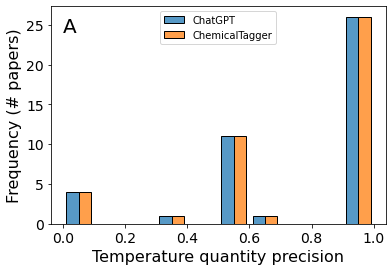

Temperature value parsing precision:
---------------------------------------
Chemtagger average:  75.6 % +/-  33.6 %
GPT average:         75.6 % +/-  33.6 %


In [124]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
bins = np.linspace(0,1,11)
sns.histplot(
    { 'ChatGPT':  temp_df['gpt_precision'], 'ChemTagger':temp_df['cde_precision'],}, 
    ax=ax, 
    bins=bins, 
    multiple='dodge', 
    shrink=0.8
    )

legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.set_xlabel('Temperature quantity precision', fontsize=16)
ax.set_ylabel('Frequency (# papers)', fontsize=16)
ax.legend(handles, ['ChatGPT', 'ChemicalTagger'], loc=9)
ax.annotate('A', (0,24),fontsize=20)
ax.tick_params(labelsize=14)
plt.show()
print('Temperature value parsing precision:\n---------------------------------------')
print(f"Chemtagger average: {round(100*temp_df['cde_precision'].mean(),1):>5} % +/- {round(100*temp_df['cde_precision'].std(),1):>5} %")
print(f"GPT average: {round(100*temp_df['gpt_precision'].mean(),1):>12} % +/- {round(100*temp_df['gpt_precision'].std(),1):>5} %")


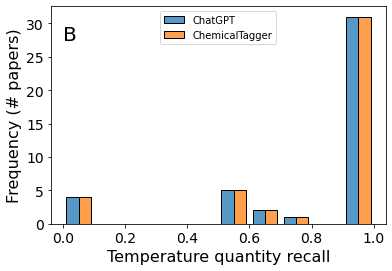

Temperature value parsing recall:
---------------------------------------
Chemtagger average:  82.8 % +/-  31.8 %
GPT average:         82.8 % +/-  31.8 %


In [126]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
bins = np.linspace(0,1,11)
sns.histplot(
    { 'ChatGPT':  temp_df['gpt_recall'], 'ChemTagger':temp_df['cde_recall'],}, 
    ax=ax, 
    bins=bins, 
    multiple='dodge', 
    shrink=0.8
    )

legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.set_xlabel('Temperature quantity recall', fontsize=16)
ax.set_ylabel('Frequency (# papers)', fontsize=16)
ax.legend(handles, ['ChatGPT', 'ChemicalTagger'], loc=9)
ax.annotate('B', (0,27.5),fontsize=20)
ax.tick_params(labelsize=14)
plt.show()
print('Temperature value parsing recall:\n---------------------------------------')
print(f"Chemtagger average: {round(100*temp_df['cde_recall'].mean(),1):>5} % +/- {round(100*temp_df['cde_recall'].std(),1):>5} %")
print(f"GPT average: {round(100*temp_df['gpt_recall'].mean(),1):>12} % +/- {round(100*temp_df['gpt_recall'].std(),1):>5} %")

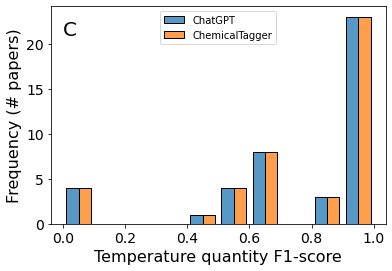

Temperature value parsing F1-score:
---------------------------------------
Chemtagger average:  77.4 % +/-  31.2 %
GPT average:         77.4 % +/-  31.2 %


In [128]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
bins = np.linspace(0,1,11)
sns.histplot(
    { 'ChatGPT':  temp_df['gpt_f1'], 'ChemTagger':temp_df['cde_f1'],}, 
    ax=ax, 
    bins=bins, 
    multiple='dodge', 
    shrink=0.8
    )

legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.set_xlabel('Temperature quantity F1-score', fontsize=16)
ax.set_ylabel('Frequency (# papers)', fontsize=16)
ax.legend(handles, ['ChatGPT', 'ChemicalTagger'], loc=9)
ax.annotate('C', (0,21),fontsize=20)
ax.tick_params(labelsize=14)
plt.show()
print('Temperature value parsing F1-score:\n---------------------------------------')
print(f"Chemtagger average: {round(100*temp_df['cde_f1'].mean(),1):>5} % +/- {round(100*temp_df['cde_f1'].std(),1):>5} %")
print(f"GPT average: {round(100*temp_df['gpt_f1'].mean(),1):>12} % +/- {round(100*temp_df['gpt_f1'].std(),1):>5} %")

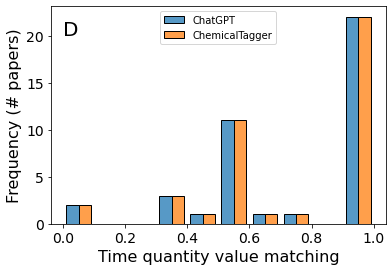

Temperature value matching:
---------------------------------------
Chemtagger average:  73.9 % +/-  31.0 %
GPT average:         73.9 % +/-  31.0 %


In [130]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
bins = np.linspace(0,1,11)
sns.histplot(
    { 'ChatGPT':  temp_df['gpt_value_match'], 'ChemTagger':temp_df['cde_value_match'],}, 
    ax=ax, 
    bins=bins, 
    multiple='dodge', 
    shrink=0.8
    )

legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.set_xlabel('Time quantity value matching', fontsize=16)
ax.set_ylabel('Frequency (# papers)', fontsize=16)
ax.legend(handles, ['ChatGPT', 'ChemicalTagger'], loc=9)
ax.annotate('D', (0,20),fontsize=20)
ax.tick_params(labelsize=14)
plt.show()
print('Temperature value matching:\n---------------------------------------')
print(f"Chemtagger average: {round(100*temp_df['cde_value_match'].mean(),1):>5} % +/- {round(100*temp_df['cde_value_match'].std(),1):>5} %")
print(f"GPT average: {round(100*temp_df['gpt_value_match'].mean(),1):>12} % +/- {round(100*temp_df['gpt_value_match'].std(),1):>5} %")